<header style="background-color:rgb(237,237,237);padding:15px;border-radius:5px">
    <h2 style="font-size:40px;text-align:center;" >Final Project</h2>
    <hr style="display: block;border-width: 1px;border-style:inset;">
    <h2 style="font-size:30px;text-align:left;" >Group members :</h2>
    <h3 style="font-size:15px;">&emsp; Joshua Nieves</h3>
    <h3 style="font-size:15px;">&emsp; Jose Viteri</h3>
</header>

In [2]:
#======================================
# Libraries Needed
#======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# A. Loading the Data
The first part of this project will be to download and view some basic information pertaining to our dataset. This will allow us to have a general idea as to how to move forward with the project as well as understand how the initial data is strucutured. 

In [4]:
#Training Data
train = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')
#test = pd.read_csv('test.csv')

In [5]:
train.head() #Test to see if you can read the data

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [6]:
train_labels.head() #Test to see if you can read the data

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      int64  
 17  hq              int64  
 18  music           int64  
 19  level_group     object 
dtypes: float64(6), int64(7), object(7)
memory usage: 3.9+ GB


#### Summary of Initial Finding
Even though we have just loaded the data, there are several key features that can be idenitified. These will need to be addressed moving forward and will be vital to the creation of model:
1. As shown by the `train.info()` the dataset that we are using is massive:
    * Before we begin dealing with any type of feature analysis we must reduce the amount of memory used up by our system. 
    * The result of this is to improve the performance of the runtime of our model <br><br>
2. The dataset, while large, consisits of several observations pertaining to the same `session_id`. 
    * This implies that we will need to perform some aggreagation prior to any modeling. 

# B. Reducing Memory Usage of the Dataset
Having now downloaded data, we will make it more manegagble to use by reducing the memory required to process it.

In [8]:
# Function to reduce memory
def reduce_memory(df):   
    for col in df.columns:
        col_type = df[col].dtype.name
        
        #Only focuses on numerical data (categorical data is handled later)
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')): #DateTime object and Category object
            if (col_type != 'object'): #Object type
                col_min = df[col].min()
                col_max = df[col].max()

                #Only focuses on if the type of the attribute is of type 'int'
                # np.iinfo() finds the Machine Limits for the data type
                if str(col_type)[:3] == 'int':
                    #Case 1: If the Machine Limits of the attribute fall between those of type int8
                    if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8) #Changes the type to int8
                    #Case 2: If the Machine Limits of the attribute fall between those of type int16
                    elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16) #Changes the type to int16
                    #Case 3: If the Machine Limits of the attribute fall between those of type int32
                    elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32) #Changes the type to int32
                    #Case 4: If the Machine Limits of the attribute fall between those of type int64
                    elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64) #Changes the type to int64

                #Only focuses on if the type of the attribute is of type 'float'
                # np.finfo() finds the Machine Limits for the data type
                else:
                    #Case 1: If the Machine Limits of the attribute fall between those of type float16
                    if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    #Case 1: If the Machine Limits of the attribute fall between those of type float32
                    elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    #All other cases doesn;t change
                    else:
                        pass
            
            #If the attribute is an object than it will change its type to category
            else:
                df[col] = df[col].astype('category')
    
    return df

In [9]:
#produce a copy of the dataset, but now using reduced memory. 
train_df = reduce_memory(train)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int16   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           int8    
 6   page            float16 
 7   room_coor_x     float16 
 8   room_coor_y     float16 
 9   screen_coor_x   float16 
 10  screen_coor_y   float16 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      int8    
 17  hq              int8    
 18  music           int8    
 19  level_group     category
dtypes: category(7), float16(5), float32(1), int16(1), int32(1), int64(1), int8(4)
memory usage: 1.0 GB


As the above illustrates, we have reduced the amount of memory used from `3.9+ GB` to `1.0 GB`. This is about a 75% decrease! We also will reduce the memory usage of the labels (as shown below).  

In [10]:
#produces a copy of the labels, but now using reduced memory. 
labels_df = reduce_memory(train_labels)
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424116 entries, 0 to 424115
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   session_id  424116 non-null  category
 1   correct     424116 non-null  int8    
dtypes: category(1), int8(1)
memory usage: 21.4 MB


In [11]:
labels_df['user_id']=labels_df.session_id.str.split("_", expand = True)[0]

In [12]:
del(train) #saves memory

In [13]:
#del(train_labels)

# C. Understanding the Game/Preprocessing New Dataframe
Before we begin preprocessing the data, it is important to explain the overall structure of the game. Doing so will explain some of the future changes that will be performed on our dataset for the sake of improving our models.

## I. Structure of the Game
Regardless of who is playing, each game lasts five chapters. The player must navigate the map and interact with the environment to collect clues to complete their objective. Once completed, the player will be assessed on the conclusions made based on the clues collected.

## II. Structure of Events
Each game consists of a series of events of in the `event_name` attribute. These consist of the following:

In [14]:
#Number of events in the games 
for i in train_df['event_name'].unique():
    print(i)

cutscene_click
person_click
navigate_click
observation_click
notification_click
object_click
object_hover
map_hover
map_click
checkpoint
notebook_click


Out of all of the events shown, the most important of them are the `checkpoint` event:

In [15]:
train_df[train_df['event_name'] == 'checkpoint'].head(6)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,1,5-12
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22
1019,20090312433251036,138,233752,checkpoint,basic,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,0,0-4
1414,20090312433251036,544,817609,checkpoint,basic,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,0,5-12
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,0,13-22


As the above illustrates, there are 3 checkpoint events per session; representing the three separate quizzes given. It is important to realize that **almost all the information (_excluding `elasped time`_) pertaining to these rows are intentionally removed**; as they contain specific texts and flags indicating whether the player correctly answered the question.

Because the only attribute given is the `elapsed_time` that passed, it is most likely the most important feature in determining whether a player correctly answered the question (as the longer the event would take, the move likely the player took multiple attempts to pick the correct response). Consequently, we will create a separate dataframe only containing 3 numerical features: `elasped_time`, `quiz_time`, and `section_time`:
* The `quiz_time` is calcualted by subtracting when the quiz was recorded to the previous event. The idea is the longer a player took in taking the quiz the more likely that they needed multiple attempts to select the right responses.
* The `section_time` is calculated by subtracting the `elapsed_time` occurring between each quiz (excluding the first quiz as that is already calculated correctly. The idea is the longer it took a students to get to the quiz portion the more likely they struggled in comprehending the objectives and finding the clues needed to correctly answer the questions. 

Once we ontained and scaled these features we will join it to our original dataframe so it will have these two new attributes.

In [16]:
#========================================================================================
# Creation of quiz_time column
#========================================================================================

#Dataframe containing only the elasped_time and the quiz_time for the checkpoint event
checkpoint_index = list(train_df[train_df['event_name'] == 'checkpoint'].index.values)

new_chp_index = list(train_df[train_df['event_name'] == 'checkpoint'].index.values + 1)
new_chp_index.remove(new_chp_index[-1])

#train_df.iloc[checkpoint_index]

In [17]:
joined_indx = checkpoint_index + new_chp_index #index containing checkpoint event and new chapter

In [18]:
#check
print(checkpoint_index[-1])
print(new_chp_index[-1])

26296945
26296186


In [19]:
#check to see if indicies were joined correctly
print(len(checkpoint_index))
print(len(new_chp_index))
print(len(joined_indx))

71028
71027
142055


In [20]:
#Sort the indexes into their correct placement
joined_indx.sort()

In [21]:
#Creates dataframe only containing information pertaining to the checkpoint of the data
checkpoint_df = train_df.iloc[joined_indx]
#checkpoint_df.head(6)
print(len(checkpoint_df))

142055


In [22]:
checkpoint_df = checkpoint_df[~checkpoint_df.index.duplicated(keep='first')] #removes any duplicates

In [23]:
len(checkpoint_df)

142053

In [24]:
#Creates the quiz_time attribute
checkpoint_df['quiz_time'] = checkpoint_df['elapsed_time'].shift(-1).fillna(5487952.0)-checkpoint_df['elapsed_time']

checkpoint_df.head(6) #test

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,quiz_time
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4,26625.0
165,20090312431273200,175,221485,navigate_click,undefined,5,NaN,280.50,-19.703125,653.0,...,NaN,NaN,boss,tunic.capitol_0.hall,NaN,0,0,1,5-12,277750.0
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,1,5-12,337497.0
461,20090312431273200,512,836732,navigate_click,undefined,13,NaN,290.25,-204.500000,651.0,...,NaN,NaN,NaN,tunic.capitol_1.hall,NaN,0,0,1,13-22,435947.0
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22,-1272679.0
881,20090312433251036,0,0,cutscene_click,basic,0,NaN,-395.00,84.687500,399.0,...,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,0,0-4,233752.0


Looking at the `quiz_time` attribute, there are several negative elements that periodically occur. Unfortunately, we will never know approximately how long it took to answer quiz 3 as the game would be over and the time resets (that explains why we have those negative values). To rectify the issue for our model, we will replace all negative values in the attribute by an estimate of the time that it took. Our estimation will be based on the following formula:

$$ \frac{AverageTime}{13} \times 5 $$

where:
* `TotalTime`: is the total time of both Quiz 1 and 2
* `13` are the number of questions asked in total for Quizzes 1 and 2
* `5` are the number of questions asked for Quiz 3

In [25]:
checkpoint_df = checkpoint_df[checkpoint_df['event_name'] == 'checkpoint']
checkpoint_df.head(6) #check

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,quiz_time
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4,26625.0
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,1,5-12,337497.0
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22,-1272679.0
1019,20090312433251036,138,233752,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,0,0-4,33131.0
1414,20090312433251036,544,817609,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,0,5-12,358874.0
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,0,13-22,-3815334.0


In [26]:
#converts list to values
val = checkpoint_df['quiz_time'].values
len(val)

71028

In [27]:
#changes the values of quiz_time so all the negative elements are replaced with the estimated average
quiz_time = []
for i in range(len(val)):
    if val[i] >= 0:
        quiz_time.append(val[i])
    else:
        estimate = abs(val[i-2] + val[i-1]) / 13 * 5
        quiz_time.append(estimate)

In [28]:
len(quiz_time) #check

71028

In [29]:
#Incorpates changes to quiz_time column
checkpoint_df['quiz_time'] = quiz_time
checkpoint_df.head(6)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,quiz_time
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4,26625.000000
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,1,5-12,337497.000000
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22,140046.923077
1019,20090312433251036,138,233752,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,0,0-4,33131.000000
1414,20090312433251036,544,817609,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,0,5-12,358874.000000
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,0,13-22,150771.153846


In [30]:
#================================================================
# Creation of section_time column
#================================================================
section_time = []
val = checkpoint_df['elapsed_time'].values

In [31]:
#Creates array containing the time for each section
for i in range(len(val)):
    if i == 0: #First element doesn't need to be changed
        section_time.append(val[i])
    elif i % 3 == 0: #Every 4th element does not need to be changed
        section_time.append(val[i])
    else:
        section_time.append(abs(val[i] - val[i-1])) #Takes the difference to find the time in between

In [32]:
section_time[0:10] #check

[194860,
 304375,
 773444,
 233752,
 583857,
 2997725,
 363226,
 269634,
 556190,
 192793]

In [33]:
#Creates section time
checkpoint_df['section_time'] = section_time
checkpoint_df.head(6)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,quiz_time,section_time
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,1,0-4,26625.000000,194860
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,1,5-12,337497.000000,304375
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,13-22,140046.923077,773444
1019,20090312433251036,138,233752,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,NaN,chap1_finale_c,tunic.capitol_0.hall,NaN,0,0,0,0-4,33131.000000,233752
1414,20090312433251036,544,817609,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,NaN,chap2_finale_c,tunic.capitol_1.hall,NaN,0,0,0,5-12,358874.000000,583857
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,0,13-22,150771.153846,2997725


In [34]:
#deletes variables to save memory
del(checkpoint_index)
del(new_chp_index)
del(joined_indx)
del(val)
del(quiz_time)
del(section_time)

In [35]:
train_df['elapsed_time'].describe()

count    2.629695e+07
mean     4.016694e+06
std      3.127032e+07
min      0.000000e+00
25%      4.397000e+05
50%      1.014801e+06
75%      1.747040e+06
max      1.988607e+09
Name: elapsed_time, dtype: float64

<AxesSubplot:ylabel='elapsed_time'>

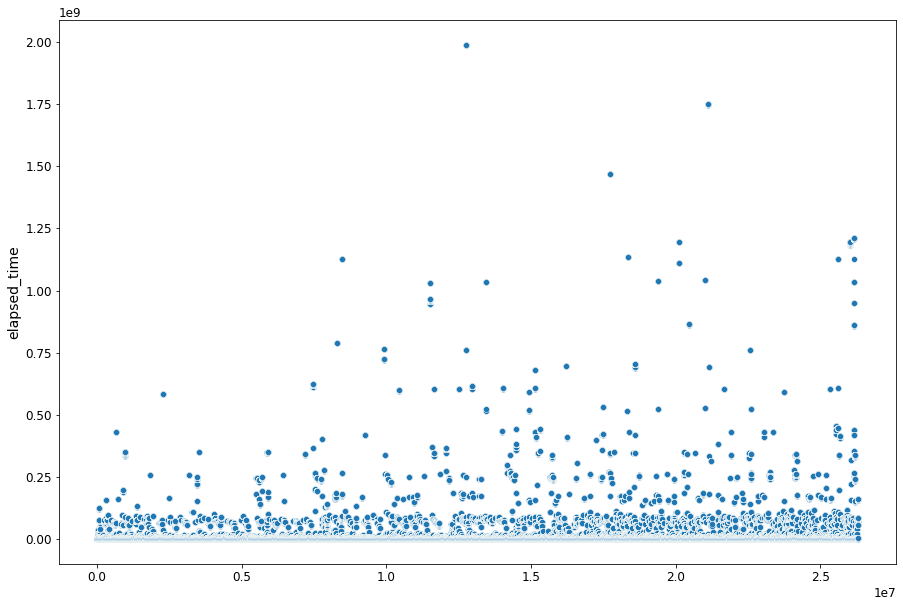

In [39]:
plt.rcParams["figure.figsize"]=15,10
sns.scatterplot(data=train_df['elapsed_time'])

Looking at the graph we can see that there are various event in the dataset that are well over what we can consider normal, many events are taking a particular user more than 5000 min to complete, this could mean there are open sessions and these could possibly be considered as outliers.

## III. Removing columns that are all NaN
Having now creating a dataframe consisting of only the `checkpoint_events` with newly created attributes. We will remove all empty columns as they are uneeded. We will use this dataframe for initial testing. We also will remove all columns that contain the same value (such as `event_name`) as they will contribute nothing to the performance of our model. 

In [40]:
attrs= ['event_name', 'name', 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'text', 'fqid',
        'room_fqid', 'text_fqid', 'hover_duration' ]

checkpoint_df = checkpoint_df.drop(columns = attrs, axis = 1)

In [41]:
checkpoint_df.head()

,session_id,index,elapsed_time,level,fullscreen,hq,music,level_group,quiz_time,section_time
164,20090312431273200,164,194860,4,0,0,1,0-4,26625.000000,194860
460,20090312431273200,470,499235,12,0,0,1,5-12,337497.000000,304375
880,20090312431273200,931,1272679,22,0,0,1,13-22,140046.923077,773444
1019,20090312433251036,138,233752,4,0,0,0,0-4,33131.000000,233752
1414,20090312433251036,544,817609,12,0,0,0,5-12,358874.000000,583857


In [42]:
del(attrs) #saves memory

# D. Preprocessing the Dataset
Having reduced the memory required to download the data and after creating an initial dataset to work with, we will now prepocess the data in preparation for the model.

In [43]:
# Creating a summary of the dataset
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['data type'])
    summary_df['#missing'] = df.isnull().sum().values * 100      #Calculates the number of missing values
    summary_df['#unique'] = df.nunique().values                  #Caluclates the number of unique values   
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summary_df['min'] = desc['min'].values                       #For numerical data, calculates the min value
    summary_df['max'] = desc['max'].values                       #For numerical data, calulcates the max value
    
    return summary_df #displays summary dataframe

In [44]:
#summary for newly created checkpoint df
checkpoint_summary = summary(checkpoint_df)
checkpoint_summary

,data type,#missing,#unique,min,max
session_id,int64,0,23562,20090312431273200.0,22100221145014656.0
index,int16,0,2435,0.0,20473.0
elapsed_time,int32,0,69855,300.0,1987182816.0
level,int8,0,3,4.0,22.0
fullscreen,int8,0,2,0.0,1.0
hq,int8,0,2,0.0,1.0
music,int8,0,2,0.0,1.0
level_group,category,0,3,NaN,NaN
quiz_time,float64,0,64737,0.0,1743228199.0
section_time,int32,0,69976,632.0,1747116080.0


In [45]:
del(checkpoint_summary) #saves memory

In [46]:
#summary for the original dataframe
summary_table = summary(train_df)
summary_table

,data type,#missing,#unique,min,max
session_id,int64,0,23562,20090312431273200.0,22100221145014656.0
index,int16,0,20348,0.0,20473.0
elapsed_time,int32,0,5042639,0.0,1988606704.0
event_name,category,0,11,NaN,NaN
name,category,0,6,NaN,NaN
level,int8,0,23,0.0,22.0
page,float16,2573240200,7,0.0,6.0
room_coor_x,float16,207327200,29854,-1992.0,1262.0
room_coor_y,float16,207327200,27847,-918.0,543.5
screen_coor_x,float16,207327200,6866,0.0,1919.0


In [47]:
del(summary_table) #saves memory

Using the summary table above, we were able to decide on perform the following tasks to modify our original dataset:
1. We can one-hot encode the attributes `event_name`, `name`, and `room_fqid` to change the categorical data into numerical ones 

2. Although the attributes `fullscreen`, `hq`, and `music` contain numerical elements, they are categorical attributes in disguise. Therefore, we will also one-hot encode these attributes aswell. 

3. The numerical attributes `elasped_time` and `hover_duration` appear to have outliers (based on the range between min and max values). Therefore, we deal with this discrepency by removing outliers

4. We must deal with all attributes pertaining to anything `text` and remove it. As we have mentioned above, the only `text` that is important is found during the `checkpoint_event`. 

## I. One-Hot Encoding Categorical Variables
The following converts all of the categorical variables of the `train_df`(excluding `text` columns) into numerical ones. *__Note: Since we will join the new attributes from `chekpoint_df` to `train_df` we will not need to convert any categorical attributes from `checkpoint_df`__*

In [50]:
# checkpoint_df.head()

In [51]:
# #========================================================================
# # One-Hot Encoding Categorical Variables for Checkpoint Dataframe
# #========================================================================
# cat_att = ['fullscreen', 'hq', 'music'] #categorical attributes (from above)

# for column in cat_att:
#     temp_df = pd.get_dummies(checkpoint_df[column], prefix=column)
    
#     checkpoint_df = pd.merge(
#         left = checkpoint_df,
#         right = temp_df,
#         left_index = True,
#         right_index = True,
#     )
    
# checkpoint_df.head()

In [52]:
# #Removing original categorical variables
# checkpoint_df = checkpoint_df.drop(columns = cat_att, axis = 1)
# checkpoint_df.head()

In [48]:
#========================================================================
# One-Hot Encoding Categorical Variables for Original Dataset
#========================================================================

cat_att = ['event_name', 'name', 'room_fqid', 'fullscreen', 'hq', 'music'] #categorical attributes (from above)

for column in cat_att:
    temp_df = pd.get_dummies(train_df[column], prefix=column)
    
    train_df = pd.merge(
        left = train_df,
        right = temp_df,
        left_index = True,
        right_index = True,
    )
    
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.kohlcenter.halloffame,room_fqid_tunic.library.frontdesk,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,...,0,0,0,0,1,0,1,0,0,1


In [49]:
#dropping the unnessary attributes
train_df = train_df.drop(columns = ['room_fqid', 'fullscreen', 'hq', 'music'], axis = 1)

In [50]:
del(cat_att) #saves memory

Notice, we are **not** dropping the `event_name` and `name` attributes even though these attributes were also categorical. That is becuase these attributes will be important in the creation of new features later on. 

In [51]:
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.kohlcenter.halloffame,room_fqid_tunic.library.frontdesk,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,...,0,0,0,0,1,0,1,0,0,1


## II. Creating the Attribute called `event_time` and Joining with the `checkpoint_df`
Having completed converting the catgorical attributes into numerical ones, we will be creating a new attribute called `event_time`:
* `event_time` measure the time an event took to complete by taking the next element in the `elapsed time` column and subtracting it from the previous element
* The `event_time` of the `checkpoint` events should contain the elements of the `quiz_time` events that we calculated earlier. Therefore, we will manually change the `event_time` column to include those values. (They were not done together as we first had to make the estimate for the third quiz).
* The `section_time` we calculated for each quiz (to denote the time it took to fully complete each quiz as wellasgather the information) we added to the `train_df`. However, only row values where the events are `checkpoint` will be filled with values. Everything else will be empty. 

In [52]:
#================================================================================================================
# Creating event time attribute 
#================================================================================================================
train_df['event_time'] = abs(train_df['elapsed_time'].shift(-1).fillna(5487952.0)-train_df['elapsed_time'])

In [53]:
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.library.frontdesk,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,event_time
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,1323.0
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,492.0
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,316.0
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,716.0
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,...,0,0,0,1,0,1,0,0,1,1560.0


In [54]:
#==================================================================================================================
# Joining the quiz_time into the event_time
#==================================================================================================================
org_indx = list(train_df[train_df['event_name'] == 'checkpoint'].index) #indicies of checkpoint event in train_df
chk_indx = list(checkpoint_df['quiz_time'].index) #indicies of checkpoint event in checkpoint_df

#Check to make sure there are no duplicates
print(len(org_indx))
print(len(chk_indx))

71028
71028


In [55]:
train_df.loc[org_indx,'event_time'] = checkpoint_df.loc[chk_indx, 'quiz_time']

In [56]:
#check to see if it matches correctly
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.library.frontdesk,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,event_time
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,1323.0
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,492.0
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,316.0
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,1,0,1,0,0,1,716.0
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,...,0,0,0,1,0,1,0,0,1,1560.0


In [57]:
train_df[train_df['event_name'] == 'checkpoint'].head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.library.frontdesk,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,event_time
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,0,0,0,1,0,1,0,0,1,26625.000000
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,0,0,0,1,0,1,0,0,1,337497.000000
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,0,0,0,1,0,1,0,0,1,140046.923077
1019,20090312433251036,138,233752,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,0,0,0,1,0,1,0,1,0,33131.000000
1414,20090312433251036,544,817609,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,0,0,0,1,0,1,0,1,0,358874.000000


In [58]:
checkpoint_df.head()

,session_id,index,elapsed_time,level,fullscreen,hq,music,level_group,quiz_time,section_time
164,20090312431273200,164,194860,4,0,0,1,0-4,26625.000000,194860
460,20090312431273200,470,499235,12,0,0,1,5-12,337497.000000,304375
880,20090312431273200,931,1272679,22,0,0,1,13-22,140046.923077,773444
1019,20090312433251036,138,233752,4,0,0,0,0-4,33131.000000,233752
1414,20090312433251036,544,817609,12,0,0,0,5-12,358874.000000,583857


In [59]:
#=====================================================================================================
# Add the section_time to train_df
#=====================================================================================================
train_df['section_time'] = np.nan

In [60]:
train_df.loc[org_indx,'section_time'] = checkpoint_df.loc[chk_indx, 'section_time']

In [61]:
#fillempty values with 0
train_df['section_time'] = train_df['section_time'].fillna(0)

In [62]:
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,event_time,section_time
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,1,0,1,0,0,1,1323.0,0.0
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,1,0,1,0,0,1,492.0,0.0
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,1,0,1,0,0,1,316.0,0.0
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,1,0,1,0,0,1,716.0,0.0
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,...,0,0,1,0,1,0,0,1,1560.0,0.0


In [63]:
train_df[train_df['event_name'] == 'checkpoint'].head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,event_time,section_time
164,20090312431273200,164,194860,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,1,26625.000000,194860.0
460,20090312431273200,470,499235,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,1,337497.000000,304375.0
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,0,1,140046.923077,773444.0
1019,20090312433251036,138,233752,checkpoint,basic,4,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,1,0,33131.000000,233752.0
1414,20090312433251036,544,817609,checkpoint,basic,12,NaN,NaN,NaN,NaN,...,0,0,1,0,1,0,1,0,358874.000000,583857.0


In [64]:
#saves memory
del(org_indx)
del(chk_indx)

In [65]:
# checkpoint_df is no longer needed
del(checkpoint_df)

Having now completed making all modification and adding the new features into our `train_df` we can move onto handling the outliers.

## II. Handling Outliers (Winzorization Method)
To handle the following outliers, we will cap the data values that pertain to the numerical attributes. By capping the data values, we maintain the same number of observations while still dealing with outliers. Our caps will be at the 5th percentile and 95th percentile. 

In [66]:
#===================================================================
# Confirming Outliers
#===================================================================
attr = ['elapsed_time', 'hover_duration', 'event_time'] #numerical attributes listed above

def CountOutliers(dataframe,attributes):
    num_outliers = 0
    
    print("For the dataframe, there are: ")
    
    for col in attributes:
        #Finds some Summary Statistics
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
    
        num_outliers = ((dataframe[col]<(Q1-1.5*IQR)) | (dataframe[col]>(Q3+1.5*IQR))).sum()
    
        print("There are "+ str(num_outliers) + " outliers in the " + col + " column.")

In [67]:
CountOutliers(train_df,attr) #Outliers in train_df

For the dataframe, there are: 
There are 1905440 outliers in the elapsed_time column.
There are 282683 outliers in the hover_duration column.
There are 1602432 outliers in the event_time column.


In [68]:
from scipy.stats.mstats import winsorize #library neeeded
#========================================================================================
# Removing Outliers from train_df
#========================================================================================

# Winzorization Method resticts the data of elasped_time column up to the 92nd percentile
train_df['elapsed_time_winsr'] = winsorize(train_df['elapsed_time'], limits=[None, 0.08]) #elasped time

# Winzorization Method resticts the data of elasped_time column up to the 85% percentile
mask = ~train_df['hover_duration'].isna() #displays which elements are NaN in the hover_duration column
train_df.loc[mask, 'hover_duration_winsr'] = winsorize(train_df['hover_duration'].loc[mask], limits=[None, 0.15])

# Winzorization Method resticts the data of elasped_time column up to the 93% percentile
train_df['event_time_winsr'] = winsorize(train_df['event_time'], limits=[None, 0.07]) #event time

In [69]:
#recheck outliers in checkpoint_df
attr = ['elapsed_time_winsr', 'hover_duration_winsr', 'event_time_winsr']
CountOutliers(train_df,attr) 

For the dataframe, there are: 
There are 0 outliers in the elapsed_time_winsr column.
There are 0 outliers in the hover_duration_winsr column.
There are 0 outliers in the event_time_winsr column.


In [70]:
#Drops the unnecessary columns
train_df = train_df.drop(columns = ['elapsed_time', 'hover_duration', 'event_time'], axis = 1)

In [71]:
#removing columns pertaining to text
train_df = train_df.drop(columns = ['text', 'text_fqid'], axis = 1)

In [72]:
train_df.head()

,session_id,index,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,...,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,section_time,elapsed_time_winsr,hover_duration_winsr,event_time_winsr
0,20090312431273200,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,...,1,0,1,0,0,1,0.0,0,NaN,1323.0
1,20090312431273200,1,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,...,1,0,1,0,0,1,0.0,1323,NaN,492.0
2,20090312431273200,2,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,...,1,0,1,0,0,1,0.0,831,NaN,316.0
3,20090312431273200,3,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,...,1,0,1,0,0,1,0.0,1147,NaN,716.0
4,20090312431273200,4,person_click,basic,0,NaN,-413.0,-159.375,381.0,494.0,...,1,0,1,0,0,1,0.0,1863,NaN,1560.0


In [73]:
del(attr) #saves memory

## III. Standardizing the Attributes for Checkpoint_df and Train_df
Now we will begin the modeling process by first standardizing some numeric features found in for the `checkpoint_df`. Once we also standardize the numeric features found in `train_df` we can join the numeric features of one into the other to create 2 new attributes.

In [74]:
scaler = MinMaxScaler() #create scaler
#scales the numeric attributes of the train_df
train_df[['room_coor_x_scaled']] = scaler.fit_transform(train_df[['room_coor_x']])
train_df[['room_coor_y_scaled']] = scaler.fit_transform(train_df[['room_coor_y']])
train_df[['screen_coor_x_scaled']] = scaler.fit_transform(train_df[['screen_coor_x']])
train_df[['screen_coor_y_scaled']] = scaler.fit_transform(train_df[['screen_coor_y']])
train_df[['elasped_time_scaled']] = scaler.fit_transform(train_df[['elapsed_time_winsr']])
train_df[['hover_duration_scaled']] = scaler.fit_transform(train_df[['hover_duration_winsr']])
train_df[['event_time_scaled']] = scaler.fit_transform(train_df[['event_time_winsr']])
train_df[['section_time_scaled']] = scaler.fit_transform(train_df[['section_time']])

print('Dataset shape: ', train_df.shape,'\n')
train_df.head()

Dataset shape:  (26296946, 66) 



,session_id,index,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,...,hover_duration_winsr,event_time_winsr,room_coor_x_scaled,room_coor_y_scaled,screen_coor_x_scaled,screen_coor_y_scaled,elasped_time_scaled,hover_duration_scaled,event_time_scaled,section_time_scaled
0,20090312431273200,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,...,NaN,1323.0,0.485107,0.519043,0.197998,0.343018,0.000000,NaN,0.407704,0.0
1,20090312431273200,1,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,...,NaN,492.0,0.485107,0.519043,0.197998,0.343018,0.000386,NaN,0.151618,0.0
2,20090312431273200,2,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,...,NaN,316.0,0.485107,0.519043,0.197998,0.343018,0.000242,NaN,0.097381,0.0
3,20090312431273200,3,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,...,NaN,716.0,0.485107,0.519043,0.197998,0.343018,0.000334,NaN,0.220647,0.0
4,20090312431273200,4,person_click,basic,0,NaN,-413.0,-159.375,381.0,494.0,...,NaN,1560.0,0.485352,0.519043,0.198608,0.343018,0.000543,NaN,0.480740,0.0


In [75]:
#deletes unnecessary columns
attr = ['room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'elapsed_time_winsr', 'hover_duration_winsr',
        'event_time_winsr', 'section_time']

train_df = train_df.drop(columns = attr, axis = 1)

In [76]:
train_df.head()

,session_id,index,event_name,name,level,page,fqid,level_group,event_name_checkpoint,event_name_cutscene_click,...,music_0,music_1,room_coor_x_scaled,room_coor_y_scaled,screen_coor_x_scaled,screen_coor_y_scaled,elasped_time_scaled,hover_duration_scaled,event_time_scaled,section_time_scaled
0,20090312431273200,0,cutscene_click,basic,0,NaN,intro,0-4,0,1,...,0,1,0.485107,0.519043,0.197998,0.343018,0.000000,NaN,0.407704,0.0
1,20090312431273200,1,person_click,basic,0,NaN,gramps,0-4,0,0,...,0,1,0.485107,0.519043,0.197998,0.343018,0.000386,NaN,0.151618,0.0
2,20090312431273200,2,person_click,basic,0,NaN,gramps,0-4,0,0,...,0,1,0.485107,0.519043,0.197998,0.343018,0.000242,NaN,0.097381,0.0
3,20090312431273200,3,person_click,basic,0,NaN,gramps,0-4,0,0,...,0,1,0.485107,0.519043,0.197998,0.343018,0.000334,NaN,0.220647,0.0
4,20090312431273200,4,person_click,basic,0,NaN,gramps,0-4,0,0,...,0,1,0.485352,0.519043,0.198608,0.343018,0.000543,NaN,0.480740,0.0


## IV. Preparing the Labels_df
Prior to our model, we might first deal with the issue of labels. We need to make sure that the *input label* and *outout labels* match.

In [77]:
labels_df.head()

,session_id,correct,user_id
0,20090312431273200_q1,1,20090312431273200
1,20090312433251036_q1,0,20090312433251036
2,20090312455206810_q1,1,20090312455206810
3,20090313091715820_q1,0,20090313091715820
4,20090313571836404_q1,1,20090313571836404


In [78]:
labels_df["level"] = labels_df.session_id.str.split("_", expand = True)[1]
labels_df["level"] = labels_df["level"].apply(lambda x : re.sub("\D", "",x)) 
labels_df["level"] = pd.to_numeric(labels_df["level"])
labels_df["user_id"] = pd.to_numeric(labels_df["user_id"])
labels_df["session_level"] = labels_df["level"].apply(lambda x: 0 if x <= 4 else (1 if x >= 5 and x <= 12 else 2))

In [79]:
labels_df.head()

,session_id,correct,user_id,level,session_level
0,20090312431273200_q1,1,20090312431273200,1,0
1,20090312433251036_q1,0,20090312433251036,1,0
2,20090312455206810_q1,1,20090312455206810,1,0
3,20090313091715820_q1,0,20090313091715820,1,0
4,20090313571836404_q1,1,20090313571836404,1,0


In [80]:
labels_df.tail()

,session_id,correct,user_id,level,session_level
424111,22100215342220508_q18,1,22100215342220508,18,2
424112,22100215460321130_q18,1,22100215460321130,18,2
424113,22100217104993650_q18,1,22100217104993650,18,2
424114,22100219442786200_q18,1,22100219442786200,18,2
424115,22100221145014656_q18,1,22100221145014656,18,2


In [81]:
# Questions 1-4 belong to level 1, 5-12 to level 2, 13 - 22 to level 3
labels_df.level.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int64)

In [82]:
print("Number of unique users: ",len(labels_df.user_id.unique()))
print("Number of unique sessions: ",len(labels_df.session_id.unique()))

Number of unique users:  23562
Number of unique sessions:  424116


In [83]:
org_numeric_features = train_df.copy() #copy
org_numeric_features.head()

,session_id,index,event_name,name,level,page,fqid,level_group,event_name_checkpoint,event_name_cutscene_click,...,music_0,music_1,room_coor_x_scaled,room_coor_y_scaled,screen_coor_x_scaled,screen_coor_y_scaled,elasped_time_scaled,hover_duration_scaled,event_time_scaled,section_time_scaled
0,20090312431273200,0,cutscene_click,basic,0,NaN,intro,0-4,0,1,...,0,1,0.485107,0.519043,0.197998,0.343018,0.000000,NaN,0.407704,0.0
1,20090312431273200,1,person_click,basic,0,NaN,gramps,0-4,0,0,...,0,1,0.485107,0.519043,0.197998,0.343018,0.000386,NaN,0.151618,0.0
2,20090312431273200,2,person_click,basic,0,NaN,gramps,0-4,0,0,...,0,1,0.485107,0.519043,0.197998,0.343018,0.000242,NaN,0.097381,0.0
3,20090312431273200,3,person_click,basic,0,NaN,gramps,0-4,0,0,...,0,1,0.485107,0.519043,0.197998,0.343018,0.000334,NaN,0.220647,0.0
4,20090312431273200,4,person_click,basic,0,NaN,gramps,0-4,0,0,...,0,1,0.485352,0.519043,0.198608,0.343018,0.000543,NaN,0.480740,0.0


In [84]:
org_numeric_features.shape,labels_df.shape

((26296946, 58), (424116, 5))

In [85]:
train_df['level'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int8)

In [86]:
len(org_numeric_features['session_id'].unique()),len(labels_df['user_id'].unique()) #train_labels

(23562, 23562)

In [87]:
# Creating a copy of my labels so I can modify the column names and keep the raw dataset intact
labels_df_cp= labels_df.copy()
labels_df_cp.rename(columns = {'session_id':'session_res','user_id':'session_id'}, inplace = True)
labels_df_cp.head()
# There is no level 0 in the training labels provided, how should we handle this?
train_df_cp = train_df.copy()
df_full = pd.merge(train_df_cp, labels_df_cp, how='inner',on=['session_id','level'])
df_full.shape

(20732578, 61)

In [88]:
df_full.head()

,session_id,index,event_name,name,level,page,fqid,level_group,event_name_checkpoint,event_name_cutscene_click,...,room_coor_y_scaled,screen_coor_x_scaled,screen_coor_y_scaled,elasped_time_scaled,hover_duration_scaled,event_time_scaled,section_time_scaled,session_res,correct,session_level
0,20090312431273200,28,navigate_click,undefined,1,NaN,retirement_letter,0-4,0,0,...,0.608887,0.229858,0.210327,0.008198,NaN,1.000000,0.0,20090312431273200_q1,1,0
1,20090312431273200,29,notification_click,basic,1,NaN,NaN,0-4,0,0,...,0.626465,0.399658,0.211792,0.009399,NaN,0.257011,0.0,20090312431273200_q1,1,0
2,20090312431273200,30,notification_click,basic,1,NaN,NaN,0-4,0,0,...,0.589844,0.399658,0.249268,0.009642,NaN,0.364253,0.0,20090312431273200_q1,1,0
3,20090312431273200,31,notification_click,basic,1,NaN,NaN,0-4,0,0,...,0.589844,0.399658,0.249268,0.009987,NaN,0.674268,0.0,20090312431273200_q1,1,0
4,20090312431273200,32,object_click,close,1,NaN,retirement_letter,0-4,0,0,...,0.792969,0.435791,0.043030,0.010625,NaN,0.026810,0.0,20090312431273200_q1,1,0


# E. Determining and Modeling Our Data
Now we will begin the modeling process. For our dataset, we will be creating two sets of model. One will be a sequential model, the other a RNN. For each model we will be determine the ideal hyperparameters needed to get the best score.

## I. Sequential Model
### a. Determining the Number of Layers and Nodes Using GridSearch

In [101]:
def summarize_events(df):
    dfs = []
    # Summarizing the number of times a particular event is occurring based on the session
    temp = df.groupby(by = ["session_id", "event_name"])["index"].count()
    # Counting the number of unique sessions
    event_total = df.groupby(by = ["session_id"])["index"].count()
    event_names = temp.index.get_level_values(1).unique()
    print('Unique event names: ',event_names,'\n')
#     event_names = ['fullscreen','hq','music','elapsed_time']
    for event_name in event_names:
        temp_by_event_name = temp.loc[:, event_name] / event_total
        temp_by_event_name = temp_by_event_name.rename(f"{event_name}_pct")
        dfs.append(temp_by_event_name)
    return dfs

In [102]:
# Only used when we take into account different features of the dataset, in our case we will only be looking at the events for now
def concat_features(df):
    
    dfs1 = summarize_events(df)

    dfs_total = dfs1
    independent_var = pd.concat(dfs_total,axis=1)
    independent_var = independent_var.fillna(-1)
    independent_var = independent_var.reset_index()
    independent_var = independent_var.set_index('session_id')
    return independent_var

In [95]:
df_full['hover_duration_scaled'] = df_full['hover_duration_scaled'].fillna(0)

In [96]:
df_full.head()

,session_id,index,event_name,name,level,page,fqid,level_group,event_name_checkpoint,event_name_cutscene_click,...,room_coor_y_scaled,screen_coor_x_scaled,screen_coor_y_scaled,elasped_time_scaled,hover_duration_scaled,event_time_scaled,section_time_scaled,session_res,correct,session_level
0,20090312431273200,28,navigate_click,undefined,1,NaN,retirement_letter,0-4,0,0,...,0.608887,0.229858,0.210327,0.008198,0.0,1.000000,0.0,20090312431273200_q1,1,0
1,20090312431273200,29,notification_click,basic,1,NaN,NaN,0-4,0,0,...,0.626465,0.399658,0.211792,0.009399,0.0,0.257011,0.0,20090312431273200_q1,1,0
2,20090312431273200,30,notification_click,basic,1,NaN,NaN,0-4,0,0,...,0.589844,0.399658,0.249268,0.009642,0.0,0.364253,0.0,20090312431273200_q1,1,0
3,20090312431273200,31,notification_click,basic,1,NaN,NaN,0-4,0,0,...,0.589844,0.399658,0.249268,0.009987,0.0,0.674268,0.0,20090312431273200_q1,1,0
4,20090312431273200,32,object_click,close,1,NaN,retirement_letter,0-4,0,0,...,0.792969,0.435791,0.043030,0.010625,0.0,0.026810,0.0,20090312431273200_q1,1,0


Because the Submission API is split into different level groups, it is necessary to split these into 3 different groups pertaining to the levels

In [105]:
X_train1= df_full[df_full["level_group"] == "0-4"]
FEATURES1 = concat_features(X_train1)
print("FEATURES1 SUCCESSFULLY GENERATED\n")

X_train2 = df_full[df_full["level_group"] == "5-12"]
FEATURES2 = concat_features(X_train2)
print("FEATURES2 SUCCESSFULLY GENERATED\n")

X_train3 = df_full[df_full["level_group"] == "13-22"]
FEATURES3 = concat_features(X_train3)
print("FEATURES3 SUCCESSFULLY GENERATED\n")

Unique event names:  CategoricalIndex(['checkpoint', 'cutscene_click', 'map_click', 'map_hover',
                  'navigate_click', 'notebook_click', 'notification_click',
                  'object_click', 'object_hover', 'observation_click',
                  'person_click'],
                 categories=['checkpoint', 'cutscene_click', 'map_click', 'map_hover', 'navigate_click', 'notebook_click', 'notification_click', 'object_click', ...], ordered=False, dtype='category', name='event_name') 

FEATURES1 SUCCESSFULLY GENERATED

Unique event names:  CategoricalIndex(['checkpoint', 'cutscene_click', 'map_click', 'map_hover',
                  'navigate_click', 'notebook_click', 'notification_click',
                  'object_click', 'object_hover', 'observation_click',
                  'person_click'],
                 categories=['checkpoint', 'cutscene_click', 'map_click', 'map_hover', 'navigate_click', 'notebook_click', 'notification_click', 'object_click', ...], ordered=False, dtype

In [133]:
FEATURES1.shape

(23562, 11)

In [141]:
df_full.shape

(20732578, 61)

In [146]:
FEATURES1_1 = df_full[df_full["level_group"] == "0-4"]
FEATURES1_1lbl = FEATURES1_1['correct']
FEATURES1_1 = FEATURES1_1.loc[:, FEATURES1_1.columns.difference(['correct','event_name','name','fqid','level_group','session_res'])]

# FEATURES1_1 = FEATURES1_1.loc[:, FEATURES1_1.columns!=['correct','event_name','name','fqid','level_group','session_res']]

FEATURES2_1 = df_full[df_full["level_group"] == "5-12"]
FEATURES2_1lbl = FEATURES2_1['correct']
FEATURES2_1 = FEATURES2_1.loc[:, FEATURES2_1.columns.difference(['correct','event_name','name','fqid','level_group','session_res'])]

# FEATURES2_1 = FEATURES2_1.loc[:, FEATURES2_1.columns!='correct']

FEATURES3_1 = df_full[df_full["level_group"] == "13-22"]
FEATURES3_1lbl = FEATURES3_1['correct']
FEATURES3_1 = FEATURES3_1.loc[:, FEATURES3_1.columns.difference(['correct','event_name','name','fqid','level_group','session_res'])]

# FEATURES3_1 = FEATURES3_1.loc[:, FEATURES3_1.columns!='correct']
# FEATURES1_1lbl = FEATURES1_1['correct']

In [144]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20732578 entries, 0 to 20732577
Data columns (total 61 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   session_id                                         int64   
 1   index                                              int16   
 2   event_name                                         category
 3   name                                               category
 4   level                                              int8    
 5   page                                               float16 
 6   fqid                                               category
 7   level_group                                        category
 8   event_name_checkpoint                              uint8   
 9   event_name_cutscene_click                          uint8   
 10  event_name_map_click                               uint8   
 11  event_name_map_hover               

In [140]:
FEATURES1_1.shape

(3292013, 60)

In [137]:
print(type(FEATURES1_1lbl.shape),type(FEATURES1_1.shape))
# type(FEATURES1_1)
# FEATURES1_1.shape

<class 'tuple'> <class 'tuple'>


In [145]:
del FEATURES1_1,FEATURES2_1,FEATURES3_1,FEATURES1_1lbl,FEATURES2_1lbl,FEATURES3_1lbl

In [148]:
# def pred_questions():
MODELS = {}
for question in range(1, 19):
    print(f'\nTRAIN QUESTION {question} MODEL')
    
    if question <= 3:
        X = FEATURES1_1
        y = FEATURES1_1lbl
    elif question <= 13:
        X = FEATURES2-1
        y = FEATURES2_1lbl
    elif question <= 18:
        X = FEATURES3_1
        y = FEATURES3_1lbl
#     y = labels_df[labels_df["level"] == question]["correct"]
    x_train,x_val = X[:int(len(X)*.8)],X[int(len(X)*.8):]
    y_train,y_val = y[:int(len(y)*.8)],y[int(len(y)*.8):]
    print(x_train.shape)
    model = 'model_'+str(question)
    model = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=(55,),activation="relu"),
    keras.layers.Dense(4, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
    print("\n\tTRAINING ",model," :")
    history = model.fit(x_train, y_train, epochs=1,
                    validation_data=(x_val, y_val))
    
    MODELS[f"question {question} model"] = model
    print(f'QUESTION {question} MODEL COMPLETE')


TRAIN QUESTION 1 MODEL
(2633610, 55)

	TRAINING  <keras.engine.sequential.Sequential object at 0x000001EBAF0B49A0>  :
82301/82301 [==============================] - 146s 2ms/step - loss: nan - accuracy: 0.1302 - val_loss: nan - val_accuracy: 0.1296
QUESTION 1 MODEL COMPLETE

TRAIN QUESTION 2 MODEL
(2633610, 55)

	TRAINING  <keras.engine.sequential.Sequential object at 0x000001EA31165F40>  :
82301/82301 [==============================] - 147s 2ms/step - loss: nan - accuracy: 0.1302 - val_loss: nan - val_accuracy: 0.1296
QUESTION 2 MODEL COMPLETE

TRAIN QUESTION 3 MODEL
(2633610, 55)

	TRAINING  <keras.engine.sequential.Sequential object at 0x000001EA31910850>  :
82301/82301 [==============================] - 138s 2ms/step - loss: nan - accuracy: 0.1302 - val_loss: nan - val_accuracy: 0.1296
QUESTION 3 MODEL COMPLETE

TRAIN QUESTION 4 MODEL
(18849, 11)

	TRAINING  <keras.engine.sequential.Sequential object at 0x000001EA3330F190>  :


ValueError: Data cardinality is ambiguous:
  x sizes: 18849
  y sizes: 7075390
Make sure all arrays contain the same number of samples.

In [91]:
#Selected attributes we deem important
attr= ['event_name_checkpoint', 'fullscreen_0', 'fullscreen_1', 'hq_0', 'hq_1', 'music_0', 'music_1','room_coor_x_scaled', 
       'room_coor_y_scaled', 'screen_coor_x_scaled','screen_coor_y_scaled', 'elasped_time_scaled', 'hover_duration_scaled',
       'event_time_scaled', 'section_time_scaled']
len(attr)

15

In [97]:
training_data=df_full[attr]
label_data=df_full[['correct']]
print('Training data shape: ',training_data.shape,'\n','Label data shape: ',label_data.shape)
x_train,x_val = training_data[:int(len(training_data)*.8)],training_data[int(len(training_data)*.8):]
y_train,y_val = label_data[:int(len(label_data)*.8)],label_data[int(len(label_data)*.8):]
print('X train shape: ',x_train.shape,'\n','X valid shape: ',x_val.shape)

Training data shape:  (20732578, 15) 
 Label data shape:  (20732578, 1)
X train shape:  (16586062, 15) 
 X valid shape:  (4146516, 15)


In [98]:
training_data.head()

,event_name_checkpoint,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,room_coor_x_scaled,room_coor_y_scaled,screen_coor_x_scaled,screen_coor_y_scaled,elasped_time_scaled,hover_duration_scaled,event_time_scaled,section_time_scaled
0,0,1,0,1,0,0,1,0.431641,0.608887,0.229858,0.210327,0.008198,0.0,1.000000,0.0
1,0,1,0,1,0,0,1,0.556152,0.626465,0.399658,0.211792,0.009399,0.0,0.257011,0.0
2,0,1,0,1,0,0,1,0.556152,0.589844,0.399658,0.249268,0.009642,0.0,0.364253,0.0
3,0,1,0,1,0,0,1,0.556152,0.589844,0.399658,0.249268,0.009987,0.0,0.674268,0.0
4,0,1,0,1,0,0,1,0.577637,0.792969,0.435791,0.043030,0.010625,0.0,0.026810,0.0


In [99]:
import math #Library Needed

def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    layers = []
    
    nodes_increment = (last_layer_nodes - first_layer_nodes)/ (n_layers-1)
    nodes = first_layer_nodes
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment
    
    return layers

In [100]:
FindLayerNodesLinear(5, 128, 8) #Test Example

[128, 98, 68, 38, 8]

In [101]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV #library needed

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [103]:
def createSeqModel(n_layers, first_layer_nodes, last_layer_nodes, activation_func, drop_rate):
    model = Sequential()
    
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    
    for i in range(1, n_layers):
        if i==1:
            model.add(BatchNormalization())
            model.add(Dropout(drop_rate))
            model.add(Dense(first_layer_nodes, input_shape = (15,) , activation = activation_func))
        else:
            model.add(BatchNormalization())
            model.add(Dropout(drop_rate))
            model.add(Dense(n_nodes[i-1], activation = activation_func))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dropout(drop_rate))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(optimizer = "adam",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    
    return model

##Wrap model into scikit-learn
seq_model =  KerasClassifier(build_fn=createSeqModel)  

C:\Users\viter\AppData\Local\Temp\ipykernel_19348\1669907450.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  seq_model =  KerasClassifier(build_fn=createSeqModel)


In [104]:
#====================================================================================================
# Define the grid for searching the optimal parameters within the grid
#====================================================================================================
activation_funcs = ['tanh', 'relu', 'selu'] #activation functions we will test

param_grid = dict(n_layers=[3,4,5,6], # Range of Layers 
                  first_layer_nodes = [512, 256, 128], #Range of Nodes
                  last_layer_nodes = [8],  
                  activation_func = activation_funcs,
                  drop_rate = [.20, .30],
                  batch_size = [64, 128, 256], 
                  epochs = [10])

grid = GridSearchCV(estimator = seq_model, param_grid = param_grid)

In [105]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
grid.fit(x_train,y_train)

Epoch 1/10
207326/207326 [==============================] - 1427s 7ms/step - loss: nan - accuracy: 0.2820
Epoch 2/10
207326/207326 [==============================] - 1016s 5ms/step - loss: nan - accuracy: 0.2820
Epoch 3/10
207326/207326 [==============================] - 1091s 5ms/step - loss: nan - accuracy: 0.2820
Epoch 4/10
207326/207326 [==============================] - 1136s 5ms/step - loss: nan - accuracy: 0.2820
Epoch 5/10
 96283/207326 [============>.................] - ETA: 17:34 - loss: nan - accuracy: 0.2820

In [122]:
# model = keras.models.Sequential([
#     keras.layers.Dense(10, input_shape=(15,),activation="relu"),
#     keras.layers.Dense(1, activation="sigmoid")
# ])

In [123]:
# model.compile(loss="binary_crossentropy",
#               optimizer="adam",
#               metrics=["accuracy"])

In [124]:
# history = model.fit(x_train, y_train, epochs=5,
#                     validation_data=(x_val, y_val))

Epoch 1/5
518315/518315 [==============================] - 379s 730us/step - loss: nan - accuracy: 0.2844 - val_loss: nan - val_accuracy: 0.2736
Epoch 2/5
518315/518315 [==============================] - 934s 2ms/step - loss: nan - accuracy: 0.2844 - val_loss: nan - val_accuracy: 0.2736
Epoch 3/5
518315/518315 [==============================] - 383s 738us/step - loss: nan - accuracy: 0.2844 - val_loss: nan - val_accuracy: 0.2736
Epoch 4/5
518315/518315 [==============================] - 419s 809us/step - loss: nan - accuracy: 0.2844 - val_loss: nan - val_accuracy: 0.2736
Epoch 5/5
518315/518315 [==============================] - 448s 863us/step - loss: nan - accuracy: 0.2844 - val_loss: nan - val_accuracy: 0.2736
